# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [5]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit',
                                        target_folder='lectures_batches', batch_size=500)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [8]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
#print topic_names,
model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2, class_ids={'text':1, 'author':1},
                  reuse_theta=True, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [9]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dict')
dictionary.gather(batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [10]:
# Ваш код
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod1', class_id='text', num_tokens=15))
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod2', class_id='author', num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [11]:
# Ваш код
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [13]:
# Ваш код
model.num_document_passes = 1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [14]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                       topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [15]:
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [16]:
# Ваш код
tokens = model.score_tracker['top_tokens_score_mod1'].last_tokens
for topic_name in model.topic_names:
    print topic_name + ': ',
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  власть средневековый император русь римский церковь святой александр сага князь папа король рассказ повесть византийский
sbj1:  звезда планета земля вещество атмосфера солнце белый газ карлик диск поверхность образовываться солнечный вокруг масса
sbj2:  система состояние трудность частота создавать поведение движение направление двигаться атом переход точность отрицательный цикл искусственный
sbj3:  культура восприятие культурный раса признак лицо сознание ощущение глаз воспринимать европа феномен глобальный представитель америка
sbj4:  право литературный владение собственность писатель римский искусство критерий быт произведение собственник доверие вещь репутация имущество
sbj5:  материал свойство молекула структура углерод применение полимер вещество поверхность атом металл кристалл углеродный использовать использование
sbj6:  книга фильм женщина автор текст литература написать тема кино герой жанр кинематограф академия читатель анекдот
sbj7:  смерть ритуал правитель государь 

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [17]:
authors = model.score_tracker['top_tokens_score_mod2'].last_tokens
for topic_name in model.topic_names:
    print topic_name + ': ',
    for author in authors[topic_name]:    
        print author,
    print

sbj0:  Александр_Марей Фёдор_Успенский Павел_Уваров Алексей_Юдин Татьяна_Бобровникова Елена_Уханова Игорь_Данилевский Ольга_Вайнштейн Григорий_Бондаренко Елена_Браун Владимир_Петрухин Ольга_Брилева Екатерина_Болтунова Ольга_Тогоева Екатерина_Лямина
sbj1:  Сергей_Попов Дмитрий_Вибе Валерий_Сулейманов Роман_Рафиков Дмитрий_Титов Александр_Потехин Наталья_Новикова Зоригто_Намсараев Александр_Слободкин Елизавета_Ривкина Игорь_Ломоносов Александр_Марков Елизавета_Бонч-Осмоловская Сергей_Наугольных Николай_Короновский
sbj2:  Александр_Поддьяков Владимир_Мележик Эмиль_Ахмедов Михаил_Фейгельман Антон_Суворов Михаил_Пантелеев Виталий_Пальчиков Илья_Щуров Алексей_Желтиков Яков_Фоминов Алексей_Котов Даниэль_Сельва Юджин_Ползик Андрей_Цатурян Андрей_Шевельков
sbj3:  Станислав_Дробышевский Павел_Степанцов Александр_Кислов Владимир_Миронов Сергей_Арутюнов Татьяна_Смоктунович Кирилл_Разлогов Павел_Умрюхин Ирина_Каспэ Андрей_Коротаев Андрей_Глазовский Фёдор_Гиренок Светлана_Кузнецова Михаил_Маяцкий Гр

In [18]:
sbj_topic_labels = []   # запишите названия тем в список
for topic_name in model.topic_names[:29]:
    sbj_topic_labels.append(tokens[topic_name][0])
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [20]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model.get_theta()
print('Theta shape: %s' % str(theta.shape))
phi_a = model.get_phi(class_ids='author')
print('Phi_a shape: %s' % str(phi_a.shape))

Theta shape: (30, 2456)
Phi_a shape: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [21]:
# Ваш код
theta.iloc[:,:100]

,http://postnauka.ru/video/49203,http://postnauka.ru/video/49206,http://postnauka.ru/video/49257,http://postnauka.ru/video/49258,http://postnauka.ru/video/49259,http://postnauka.ru/video/49261,http://postnauka.ru/video/49262,http://postnauka.ru/video/49284,http://postnauka.ru/video/49431,http://postnauka.ru/video/49432,...,http://postnauka.ru/video/51366,http://postnauka.ru/video/51367,http://postnauka.ru/video/51371,http://postnauka.ru/video/51374,http://postnauka.ru/video/51376,http://postnauka.ru/video/51378,http://postnauka.ru/video/51380,http://postnauka.ru/video/51382,http://postnauka.ru/video/51384,http://postnauka.ru/video/51486
sbj0,1.582788e-02,0.000000e+00,0.000000e+00,8.147634e-04,1.051879e-06,0.000000e+00,0.000000e+00,6.010664e-02,0.000000e+00,0.000000e+00,...,3.946893e-13,7.409681e-02,2.624002e-15,7.203165e-03,7.745827e-15,8.125953e-13,1.147271e-02,1.530994e-11,8.627538e-09,9.461354e-11
sbj1,3.192907e-07,2.358215e-04,2.461682e-03,2.202301e-12,1.034157e-02,2.977648e-01,1.796884e-02,8.212706e-09,4.684895e-04,1.383083e-02,...,1.393656e-03,2.582307e-03,9.053561e-11,2.369170e-03,1.104352e-13,0.000000e+00,0.000000e+00,1.214978e-04,1.284323e-05,7.793857e-07
sbj2,1.615733e-03,5.686700e-03,8.573582e-03,5.814445e-03,7.415946e-03,1.469768e-02,8.210594e-03,9.984769e-04,6.802216e-02,4.975997e-03,...,2.505578e-02,6.546438e-08,8.821583e-03,1.943378e-03,9.724784e-03,3.422292e-03,1.215192e-03,2.231116e-01,2.730282e-02,3.596453e-03
sbj3,3.123118e-06,7.951206e-03,0.000000e+00,5.016476e-10,1.240326e-06,1.743229e-03,2.086216e-11,4.686755e-09,5.460902e-10,1.471925e-03,...,0.000000e+00,9.893511e-04,3.824877e-11,1.527004e-05,8.429268e-10,5.011432e-04,1.156358e-03,1.253371e-03,1.430646e-02,4.850048e-09
sbj4,1.262983e-03,1.121918e-02,2.236485e-11,4.368383e-07,4.508546e-06,0.000000e+00,1.819794e-02,6.631153e-03,0.000000e+00,3.308580e-11,...,0.000000e+00,9.401453e-04,0.000000e+00,3.587976e-11,9.356666e-15,8.869696e-05,0.000000e+00,2.693298e-11,0.000000e+00,4.455968e-03
sbj5,1.018989e-03,2.009263e-03,0.000000e+00,1.622392e-05,0.000000e+00,8.110721e-03,3.566984e-03,2.231184e-11,1.577837e-02,3.295839e-07,...,4.443272e-02,0.000000e+00,9.379627e-04,4.701351e-04,2.220287e-01,1.473586e-03,9.261416e-15,3.116263e-10,1.221420e-08,2.410990e-04
sbj6,7.920850e-03,3.638323e-07,0.000000e+00,2.425718e-08,5.698983e-13,0.000000e+00,2.194007e-12,4.856326e-03,0.000000e+00,0.000000e+00,...,1.161627e-16,1.611123e-03,0.000000e+00,1.095359e-09,4.217292e-03,1.125892e-04,2.180753e-10,1.369043e-04,1.321321e-08,2.984367e-03
sbj7,5.759662e-10,0.000000e+00,0.000000e+00,0.000000e+00,1.086086e-13,0.000000e+00,0.000000e+00,8.018955e-06,2.655742e-15,4.224792e-04,...,0.000000e+00,3.769580e-03,0.000000e+00,0.000000e+00,1.628464e-12,0.000000e+00,7.565451e-09,1.780485e-15,1.530062e-05,1.635012e-04
sbj8,2.704046e-06,8.141633e-03,5.488460e-02,6.252431e-03,1.963532e-02,3.643324e-03,2.135406e-02,1.851676e-06,2.646325e-03,7.156207e-03,...,8.545202e-09,2.060586e-13,1.177795e-02,1.725355e-11,1.595921e-02,6.939242e-13,3.176860e-03,1.688318e-08,6.418326e-03,3.859721e-03
sbj9,1.535734e-03,4.286030e-11,1.104708e-01,4.723110e-03,1.517130e-04,8.228668e-03,8.221596e-08,4.995633e-10,1.417848e-01,1.272846e-02,...,2.740473e-01,2.534549e-13,1.588100e-01,8.735067e-04,5.882786e-02,3.084727e-03,5.107717e-09,7.663616e-03,3.008553e-10,5.483401e-12


Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

C:\Users\hp\Anaconda2\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


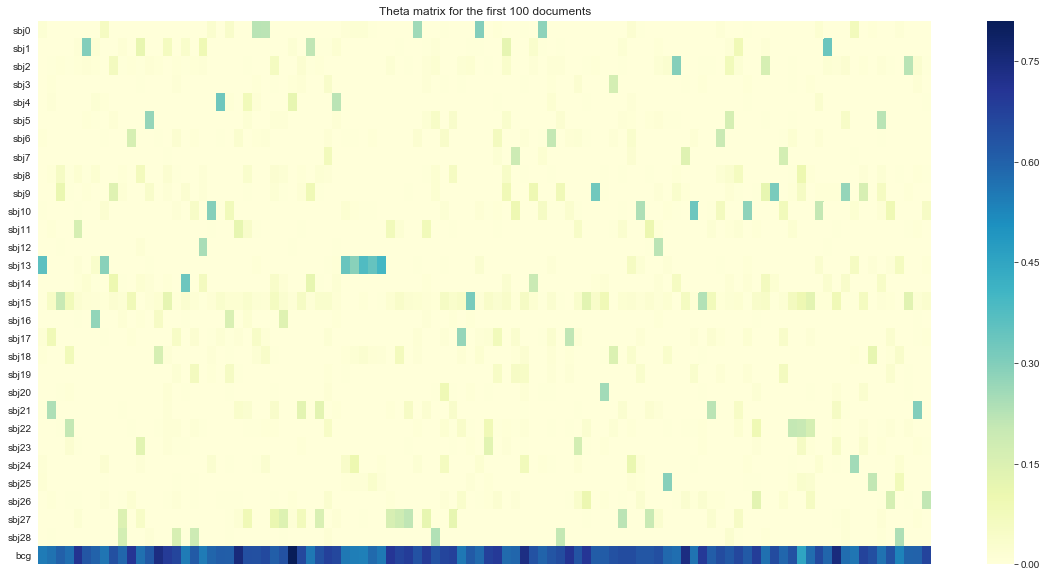

In [23]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
seaborn.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [24]:
prob_theme_data = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
prob_theme_data_normed = prob_theme_data / np.sum(prob_theme_data)
prob_theme = pd.DataFrame(data=prob_theme_data_normed, index=topic_labels, columns=['prob'])
prob_theme

,prob
власть,0.013820
звезда,0.014398
система,0.011769
культура,0.012948
право,0.008445
материал,0.011859
книга,0.010627
смерть,0.005134
наука,0.050000
частица,0.024227


In [25]:
prob_theme_max = prob_theme
prob_theme_min = prob_theme

print('Max 5 probabilities:')
for i in range(5):
    max_value = prob_theme_max.max()[0]
    print(prob_theme_max[prob_theme_max.values == max_value].index[0])
    prob_theme_max = prob_theme_max[prob_theme_max.values != max_value]

print('\nMin 3 probabilities:')
for i in range(3):
    min_value = prob_theme_min.min()[0]
    print(prob_theme_min[prob_theme_min.values == min_value].index[0])
    prob_theme_min = prob_theme_min[prob_theme_min.values != min_value]

Max 5 probabilities:
Фоновая тема
наука
человек
клетка
частица

Min 3 probabilities:
структура
смерть
университет


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

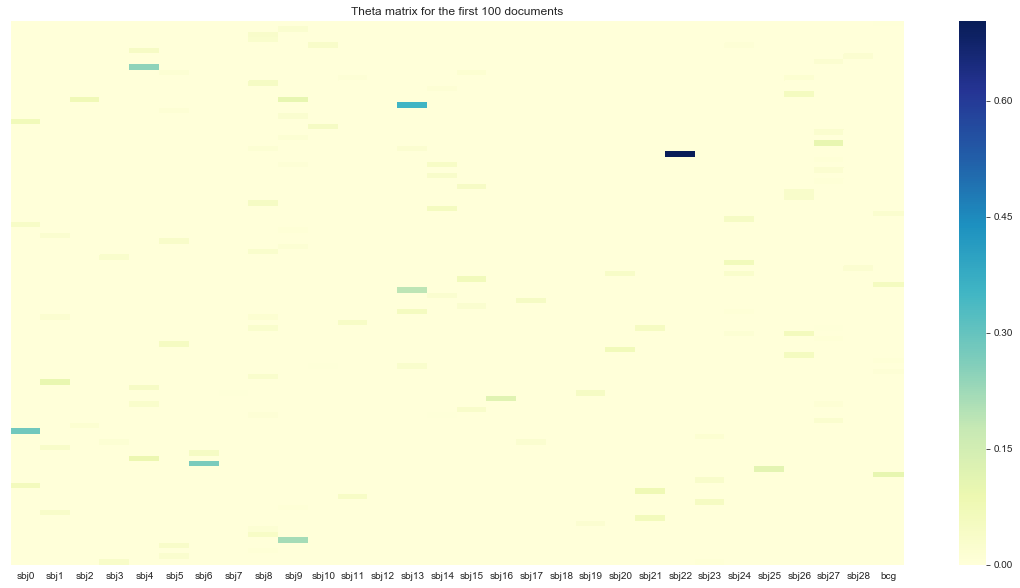

In [26]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
seaborn.heatmap(phi_a.iloc[:100], cmap='YlGnBu', yticklabels=False)
plt.show();

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [27]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,1.089779e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,3.680677e-03
Сергей_Демокритов,0.000000e+00,0.000000e+00,5.286201e-13,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,2.427915e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Руслан_Смелянский,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.438973e-02,0.000000e+00,...,1.856070e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Александр_Апт,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.755540e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,3.301440e-11,0.000000e+00,0.000000e+00
Людмила_Новикова,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.935828e-03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Александр_Парфенов,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,4.620346e-02,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Джеффри_Шнапп,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,2.392130e-08,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,2.048813e-02,0.000000e+00
Дмитрий_Чудаков,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.775216e-12,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,2.010689e-02,0.000000e+00,0.000000e+00
Дмитрий_Дождев,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.445573e-01,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
Владимир_Шалаев,0.000000e+00,0.000000e+00,6.338236e-05,0.000000,0.000000e+00,1.602329e-02,0.000000e+00,0.0,1.616476e-03,1.269388e-15,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00


In [28]:
for i in range(phi_a.shape[0]):
    num_valuble_topics = 0
    for val in phi_a.iloc[i]:
        if val > 0.01:
            num_valuble_topics += 1
    if num_valuble_topics >= 3:
        print(i),
        print(phi_a.index[i])

104 Александр_Жаворонков
133 Михаил_Маяцкий
142 Станислав_Дробышевский
173 Дина_Гусейнова
200 Андрей_Цатурян
332 Елизавета_Бонч-Осмоловская
407 Владимир_Кантор
471 Ольга_Вайнштейн
479 Андрей_Журавлев
502 Ольга_Тогоева


In [29]:
print(phi_a.iloc[104])

sbj0     0.000000
sbj1     0.000000
sbj2     0.000000
sbj3     0.000000
sbj4     0.000000
sbj5     0.000000
sbj6     0.000000
sbj7     0.000000
sbj8     0.019431
sbj9     0.000000
sbj10    0.000000
sbj11    0.012699
sbj12    0.000000
sbj13    0.000000
sbj14    0.000000
sbj15    0.000000
sbj16    0.000000
sbj17    0.000000
sbj18    0.000000
sbj19    0.000000
sbj20    0.000000
sbj21    0.000006
sbj22    0.000000
sbj23    0.043880
sbj24    0.000000
sbj25    0.000000
sbj26    0.000000
sbj27    0.000000
sbj28    0.000000
bcg      0.000000
Name: Александр_Жаворонков, dtype: float32


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [30]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [31]:
# Ваш код
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)

In [32]:
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

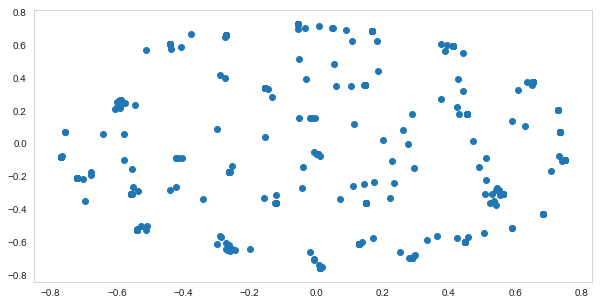

In [33]:
# Ваш код
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

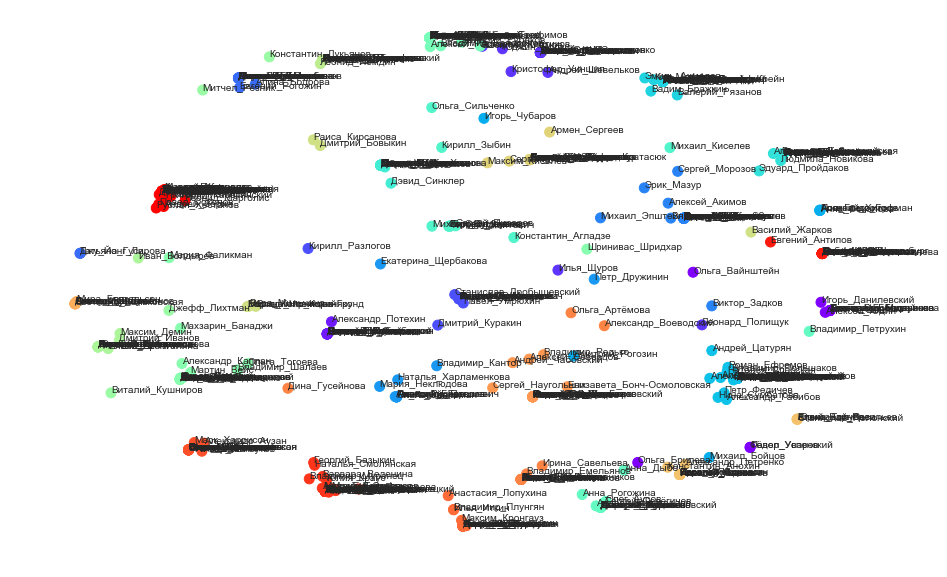

In [34]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [35]:
# Ваш код
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[ 442, 1170, 1713, ...,  860,  858, 1227],
       [ 897,  169, 1677, ..., 1989, 1990, 1958],
       [ 799,   71, 2327, ..., 1984, 1982, 2455],
       ...,
       [ 326, 1054, 1965, ...,  574, 1719,    0],
       [1604,   96,  824, ..., 1368, 1174, 2096],
       [ 756,   28, 1635, ...,  442, 2045, 1757]], dtype=int64)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [36]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [37]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [38]:
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[model.topic_names[i]][j]),
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

власть средневековый император русь римский церковь святой александр сага князь 
http://postnauka.ru/video/9299
http://postnauka.ru/video/9299
http://postnauka.ru/video/3348
http://postnauka.ru/video/24034
http://postnauka.ru/video/24039
http://postnauka.ru/video/42999
http://postnauka.ru/video/42999
http://postnauka.ru/video/28942
http://postnauka.ru/video/50350
http://postnauka.ru/video/50350


звезда планета земля вещество атмосфера солнце белый газ карлик диск 
http://postnauka.ru/video/53693
http://postnauka.ru/video/53693
http://postnauka.ru/video/31695
http://postnauka.ru/video/9835
http://postnauka.ru/video/9835
http://postnauka.ru/video/51364
http://postnauka.ru/video/51364
http://postnauka.ru/video/25281
http://postnauka.ru/video/36249
http://postnauka.ru/video/32889


система состояние трудность частота создавать поведение движение направление двигаться атом 
http://postnauka.ru/video/51174
http://postnauka.ru/video/51174
http://postnauka.ru/video/21662
http://postnauka.ru/video/52548
http://postnauka.ru/video/52548
http://postnauka.ru/video/51382
http://postnauka.ru/video/51382
http://postnauka.ru/video/56618
http://postnauka.ru/video/56618
http://postnauka.ru/video/1856


культура восприятие культурный раса признак лицо сознание ощущение глаз воспринимать 
http://postnauka.ru/video/17397
http://postnauka.ru/video/37990
http://postnauka.ru/video/17041
http://postnauka.ru/video/12740
http://postnauka.ru/video/13180
http://postnauka.ru/video/40880
http://postnauka.ru/video/40880
http://postnauka.ru/video/12524
http://postnauka.ru/video/42735
http://postnauka.ru/video/42735


право литературный владение собственность писатель римский искусство критерий быт произведение 
http://postnauka.ru/video/17913
http://postnauka.ru/video/38009
http://postnauka.ru/video/31688
http://postnauka.ru/video/49455
http://postnauka.ru/video/49455
http://postnauka.ru/video/34414
http://postnauka.ru/video/16822
http://postnauka.ru/video/31666
http://postnauka.ru/video/39998
http://postnauka.ru/video/36715


материал свойство молекула структура углерод применение полимер вещество поверхность атом 
http://postnauka.ru/video/13544
http://postnauka.ru/video/31182
http://postnauka.ru/video/41686
http://postnauka.ru/video/41686
http://postnauka.ru/video/46379
http://postnauka.ru/video/46379
http://postnauka.ru/video/35065
http://postnauka.ru/video/49439
http://postnauka.ru/video/49439
http://postnauka.ru/video/36657


книга фильм женщина автор текст литература написать тема кино герой 
http://postnauka.ru/video/39723
http://postnauka.ru/video/10759
http://postnauka.ru/video/42807
http://postnauka.ru/video/42807
http://postnauka.ru/video/47204
http://postnauka.ru/video/47204
http://postnauka.ru/video/57010
http://postnauka.ru/video/57010
http://postnauka.ru/video/47202
http://postnauka.ru/video/47202


смерть ритуал правитель государь тело обряд конвент орден террор монтаньяр 
http://postnauka.ru/video/1893
http://postnauka.ru/video/48480
http://postnauka.ru/video/48480
http://postnauka.ru/video/47449
http://postnauka.ru/video/47449
http://postnauka.ru/video/42803
http://postnauka.ru/video/42803
http://postnauka.ru/video/32882
http://postnauka.ru/video/50656
http://postnauka.ru/video/50656


наука рассказывать метод какой доктор каков химический реакция соединение кандидат 
http://postnauka.ru/video/7363
http://postnauka.ru/video/7363
http://postnauka.ru/video/12971
http://postnauka.ru/video/9861
http://postnauka.ru/video/9861
http://postnauka.ru/video/8953
http://postnauka.ru/video/8953
http://postnauka.ru/video/10786
http://postnauka.ru/video/9144
http://postnauka.ru/video/9144


частица теория взаимодействие квантовый поле физика энергия электрон кварк симметрия 
http://postnauka.ru/video/13043
http://postnauka.ru/video/22760
http://postnauka.ru/video/18873
http://postnauka.ru/video/47952
http://postnauka.ru/video/47952
http://postnauka.ru/video/53507
http://postnauka.ru/video/53507
http://postnauka.ru/video/7311
http://postnauka.ru/video/7311
http://postnauka.ru/video/47950


война россия советский русский власть российский германия страна мировой народ 
http://postnauka.ru/video/19574
http://postnauka.ru/video/31183
http://postnauka.ru/video/46939
http://postnauka.ru/video/46939
http://postnauka.ru/video/35041
http://postnauka.ru/video/9561
http://postnauka.ru/video/9561
http://postnauka.ru/video/29992
http://postnauka.ru/video/25906
http://postnauka.ru/video/12148


ребенок семья возраст взрослый мать родитель сон катастрофа кровь токсин 
http://postnauka.ru/video/11361
http://postnauka.ru/video/22892
http://postnauka.ru/video/60527
http://postnauka.ru/video/60527
http://postnauka.ru/video/59638
http://postnauka.ru/video/59638
http://postnauka.ru/video/30678
http://postnauka.ru/video/57866
http://postnauka.ru/video/57866
http://postnauka.ru/video/22883


галактика скопление озеро спиральный эволюция звездный газ мышца должник вода 
http://postnauka.ru/video/48109
http://postnauka.ru/video/48109
http://postnauka.ru/video/46562
http://postnauka.ru/video/46562
http://postnauka.ru/video/42221
http://postnauka.ru/video/42221
http://postnauka.ru/video/49451
http://postnauka.ru/video/49451
http://postnauka.ru/video/58744
http://postnauka.ru/video/58744


век христианский территория восток культура письменность государство китай христианство цивилизация 
http://postnauka.ru/video/53171
http://postnauka.ru/video/53171
http://postnauka.ru/video/59201
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/50071
http://postnauka.ru/video/50071
http://postnauka.ru/video/50066
http://postnauka.ru/video/50066
http://postnauka.ru/video/3387


объект свет вселенная черный галактика излучение дыра скорость волна энергия 
http://postnauka.ru/video/6673
http://postnauka.ru/video/6673
http://postnauka.ru/video/25875
http://postnauka.ru/video/30015
http://postnauka.ru/video/7067
http://postnauka.ru/video/7067
http://postnauka.ru/video/57338
http://postnauka.ru/video/57338
http://postnauka.ru/video/49447
http://postnauka.ru/video/49447


человек задача или информация данные решение наш память решать внимание 
http://postnauka.ru/video/24451
http://postnauka.ru/video/24182
http://postnauka.ru/video/46933
http://postnauka.ru/video/46933
http://postnauka.ru/video/50349
http://postnauka.ru/video/50349
http://postnauka.ru/video/53949
http://postnauka.ru/video/53949
http://postnauka.ru/video/58752
http://postnauka.ru/video/58752


структура структурный флуоресцентный образовывать цвет волос пространственный монголоид сенсор морской 
http://postnauka.ru/video/49262
http://postnauka.ru/video/49262
http://postnauka.ru/video/56281
http://postnauka.ru/video/56281
http://postnauka.ru/video/42707
http://postnauka.ru/video/42707
http://postnauka.ru/video/49457
http://postnauka.ru/video/49457
http://postnauka.ru/video/10754
http://postnauka.ru/video/49850


политический философия право общество философский государство понятие философ закон правовой 
http://postnauka.ru/video/12738
http://postnauka.ru/video/12371
http://postnauka.ru/video/3418
http://postnauka.ru/video/32906
http://postnauka.ru/video/53044
http://postnauka.ru/video/53044
http://postnauka.ru/video/37965
http://postnauka.ru/video/42088
http://postnauka.ru/video/42088
http://postnauka.ru/video/9728


слово текст язык русский словарь значение предложение корпус перевод категория 
http://postnauka.ru/video/56616
http://postnauka.ru/video/56616
http://postnauka.ru/video/48960
http://postnauka.ru/video/48960
http://postnauka.ru/video/47548
http://postnauka.ru/video/47548
http://postnauka.ru/video/1898
http://postnauka.ru/video/36272
http://postnauka.ru/video/6720
http://postnauka.ru/video/6720


революция французский свобода роль роман король франция аргумент нация творчество 
http://postnauka.ru/video/48492
http://postnauka.ru/video/48492
http://postnauka.ru/video/43843
http://postnauka.ru/video/43843
http://postnauka.ru/video/47823
http://postnauka.ru/video/47823
http://postnauka.ru/video/45548
http://postnauka.ru/video/45548
http://postnauka.ru/video/5396
http://postnauka.ru/video/5396


город сеть робот технология городской компания интернет пользователь пространство метро 
http://postnauka.ru/video/13742
http://postnauka.ru/video/12515
http://postnauka.ru/video/11634
http://postnauka.ru/video/47301
http://postnauka.ru/video/47301
http://postnauka.ru/video/7068
http://postnauka.ru/video/7068
http://postnauka.ru/video/50792
http://postnauka.ru/video/50792
http://postnauka.ru/video/17604


болезнь заболевание пациент лечение врач боль медицина препарат медицинский операция 
http://postnauka.ru/video/54325
http://postnauka.ru/video/54325
http://postnauka.ru/video/2541
http://postnauka.ru/video/51384
http://postnauka.ru/video/51384
http://postnauka.ru/video/13746
http://postnauka.ru/video/55539
http://postnauka.ru/video/55539
http://postnauka.ru/video/43853
http://postnauka.ru/video/43853


знание объект социальный форма социология предмет социологический дисциплина смысл познание 
http://postnauka.ru/video/12083
http://postnauka.ru/video/3628
http://postnauka.ru/video/434
http://postnauka.ru/video/434
http://postnauka.ru/video/10783
http://postnauka.ru/video/11640
http://postnauka.ru/video/17491
http://postnauka.ru/video/6380
http://postnauka.ru/video/6380
http://postnauka.ru/video/17492


модель функция схема матрица алгоритм эмоция эмоциональный вычислительный интеллект программный 
http://postnauka.ru/video/52738
http://postnauka.ru/video/52738
http://postnauka.ru/video/42416
http://postnauka.ru/video/42416
http://postnauka.ru/video/2947
http://postnauka.ru/video/59633
http://postnauka.ru/video/59633
http://postnauka.ru/video/7782
http://postnauka.ru/video/7782
http://postnauka.ru/video/2529


история исторический царь миф бог греческий представление эпоха море имя 
http://postnauka.ru/video/7778
http://postnauka.ru/video/7778
http://postnauka.ru/video/12527
http://postnauka.ru/video/9997
http://postnauka.ru/video/9997
http://postnauka.ru/video/43664
http://postnauka.ru/video/43664
http://postnauka.ru/video/47300
http://postnauka.ru/video/47300
http://postnauka.ru/video/21631


язык согласный гласный говор лингвист звук программа лингвистика компилятор программирование 
http://postnauka.ru/video/13041
http://postnauka.ru/video/8964
http://postnauka.ru/video/8964
http://postnauka.ru/video/10773
http://postnauka.ru/video/7525
http://postnauka.ru/video/7525
http://postnauka.ru/video/51171
http://postnauka.ru/video/51171
http://postnauka.ru/video/3403
http://postnauka.ru/video/15343


социальный экономический политика страна экономика поведение ценность сталин конфликт кризис 
http://postnauka.ru/video/9389
http://postnauka.ru/video/9389
http://postnauka.ru/video/9429
http://postnauka.ru/video/9429
http://postnauka.ru/video/31684
http://postnauka.ru/video/6497
http://postnauka.ru/video/6497
http://postnauka.ru/video/7781
http://postnauka.ru/video/7781
http://postnauka.ru/video/56290


клетка мозг днк организм ген белок животное биологический генетический нейрон 
http://postnauka.ru/video/5915
http://postnauka.ru/video/5915
http://postnauka.ru/video/10475
http://postnauka.ru/video/5390
http://postnauka.ru/video/5390
http://postnauka.ru/video/19436
http://postnauka.ru/video/17051
http://postnauka.ru/video/6477
http://postnauka.ru/video/6477
http://postnauka.ru/video/9854


университет температура сверхпроводимость сверхпроводник профессор сверхпроводящий диабет заимствование гумбольдт ученый 
http://postnauka.ru/video/2973
http://postnauka.ru/video/51380
http://postnauka.ru/video/51380
http://postnauka.ru/video/50340
http://postnauka.ru/video/50340
http://postnauka.ru/video/31198
http://postnauka.ru/video/50699
http://postnauka.ru/video/50699
http://postnauka.ru/video/55756
http://postnauka.ru/video/55756


быть что это который этот как они такой мочь очень 
http://postnauka.ru/video/49851
http://postnauka.ru/video/49851
http://postnauka.ru/video/30625
http://postnauka.ru/video/14293
http://postnauka.ru/video/45956
http://postnauka.ru/video/45956
http://postnauka.ru/video/5602
http://postnauka.ru/video/5602
http://postnauka.ru/video/48452
http://postnauka.ru/video/48452


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 